In [ ]:
## The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from utils_projects import view_classify, imshow

import numpy as np

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

print(len(trainloader), len(testloader))

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 512),
                      nn.ReLU(),
                      nn.Linear(512, 256),
                      nn.ReLU(),
                      nn.Linear(256, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Define the loss function
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2)
optimizer.zero_grad()

# Training the network
epochs = 10
for j in range(epochs):
    running_loss = 0
    n_wrong = 0
    n_pred = 0
    wts = []
    wts_grad = []
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad() # clear gradient in each step
        logits = model.forward(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        wts.append(model[0].weight)
        wts_grad.append(model[0].weight.grad)
        running_loss += loss.item()
        pred = torch.argmax(F.softmax(logits, dim=1), dim=1)
        n_wrong += torch.sum(pred != labels)
        n_pred += logits.shape[0]
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        print(f"Wrong predictions percentage: {n_wrong/n_pred}")


# Test out your network!

dataiter = iter(testloader)
print(dir(dataiter))
images, labels = dataiter._next_data()
img = images[49]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img))
#ps = F.softmax(model.forward(img))

# Plot the image and probabilities
view_classify(img.resize_(1, 28, 28), ps, version='Fashion')

In [ ]:
## Now validate for overfitting
model = nn.Sequential(nn.Linear(784, 512),
                      nn.ReLU(),
                      nn.Linear(512, 256),
                      nn.ReLU(),
                      nn.Linear(256, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:        
        optimizer.zero_grad()  
        images = images.view(images.shape[0], -1)
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()       
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        correctness = torch.ByteTensor([])
        validation_loss = 0
        with torch.no_grad():
            for images_val, labels_val in testloader:
                images_val = images_val.view(images_val.shape[0], -1)
                logits_val = model.forward(images_val)
                loss_val = criterion(logits_val, labels_val)
                ps = torch.exp(logits_val)
                top_p, top_class = ps.topk(1, dim=1)
                equal_preds = top_class == labels_val.view(len(labels_val), -1)
                correctness = torch.cat((correctness, equal_preds), dim=0)
                validation_loss += loss_val.item()
                test_losses.append(validation_loss/len(testloader))
        accuracy = torch.mean(correctness.type(torch.FloatTensor))
        print(f'Training loss: {running_loss/len(trainloader)}')
        print(f'Validation loss: {validation_loss/len(testloader)}')
        print(f'Validation accuracy: {accuracy.item()*100}%')

Training loss: 0.7906877139547487
Validation loss: 0.58854824627281
Validation accuracy: 79.25000190734863%
Training loss: 0.5290810203692043
Validation loss: 0.5886381344430766
Validation accuracy: 79.50999736785889%
Training loss: 0.4713789696124063
Validation loss: 0.4854503549208307
Validation accuracy: 83.3400011062622%
Training loss: 0.44096518021974485
Validation loss: 0.4994199198142738
Validation accuracy: 82.66000151634216%
Training loss: 0.4174849702351129
Validation loss: 0.487784670131981
Validation accuracy: 83.39999914169312%
Training loss: 0.4022716270295033
Validation loss: 0.46136447445602174
Validation accuracy: 84.02000069618225%
Training loss: 0.38508369420954924
Validation loss: 0.45015994188891856
Validation accuracy: 84.72999930381775%
Training loss: 0.375885646782323
Validation loss: 0.43049493004941636
Validation accuracy: 85.14999747276306%
Training loss: 0.3624097692337372
Validation loss: 0.41580751661662085
Validation accuracy: 85.180002450943%
Training lo

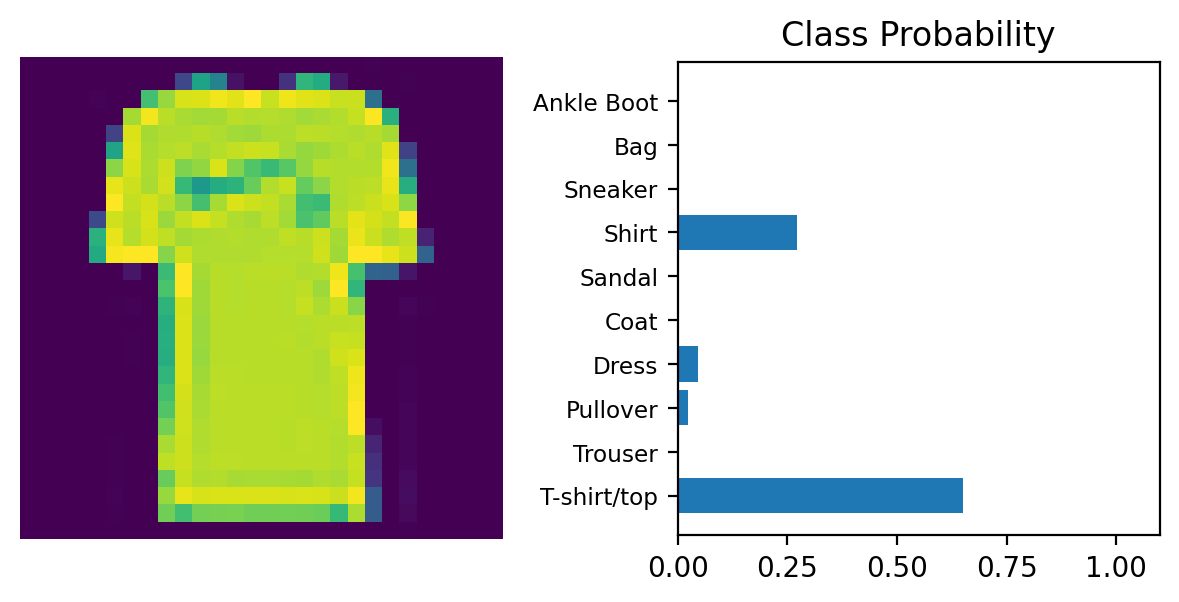

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Now include dropout layer to prevent overfitting:
model = nn.Sequential(nn.Linear(784, 512),
                      nn.ReLU(),
                      nn.Dropout(p=0.4),
                      nn.Linear(512, 256),
                      nn.ReLU(),
                      nn.Dropout(p=0.4),
                      nn.Linear(256, 64),
                      nn.ReLU(),
                      nn.Dropout(p=0.4),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:        
        optimizer.zero_grad()  
        images = images.view(images.shape[0], -1)
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()       
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        correctness = torch.ByteTensor([])
        validation_loss = 0
        with torch.no_grad():
            for images_val, labels_val in testloader:
                images_val = images_val.view(images_val.shape[0], -1)
                logits_val = model.forward(images_val)
                loss_val = criterion(logits_val, labels_val)
                ps = torch.exp(logits_val)
                top_p, top_class = ps.topk(1, dim=1)
                equal_preds = top_class == labels_val.view(len(labels_val), -1)
                correctness = torch.cat((correctness, equal_preds), dim=0)
                validation_loss += loss_val.item()
                test_losses.append(validation_loss/len(testloader))
        accuracy = torch.mean(correctness.type(torch.FloatTensor))
        print(f'Training loss: {running_loss/len(trainloader)}')
        print(f'Validation loss: {validation_loss/len(testloader)}')
        print(f'Validation accuracy: {accuracy.item()*100}%')


# Testing out the work!
model.eval()

dataiter = iter(testloader)
images, labels = dataiter._next_data()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps, version='Fashion')